In [92]:
pass_list = [0,0,0,0,0]




### 常見錯誤:
### too much error segment: please face the microphone



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
a 分析結果:
include 2.wav
最低音限制(< 26 ): 25.897 pass
最高音限制(> 39 ): 39.04 pass


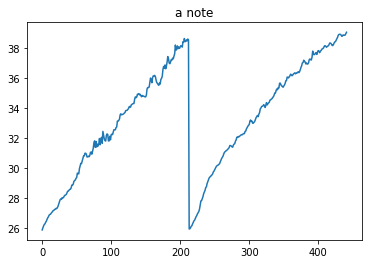

del_note(<= 0.35 ): 0.1726453522662652 pass
del_sp(< 1e-06 ): 1.5760166283989662e-10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
i 分析結果:
最低音限制(< 26 ): 25.856 pass
最高音限制(> 39 ): 39.063 pass


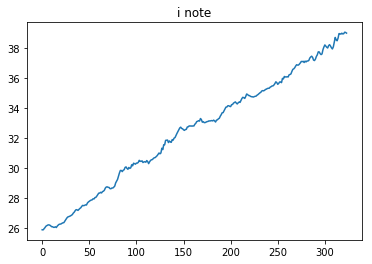

del_note(<= 0.35 ): 0.23229741614707677 pass
del_sp(< 1e-06 ): 3.295004571826912e-10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
u 分析結果:
最低音限制(< 26 ): 25.87 pass
最高音限制(> 39 ): 39.003 pass


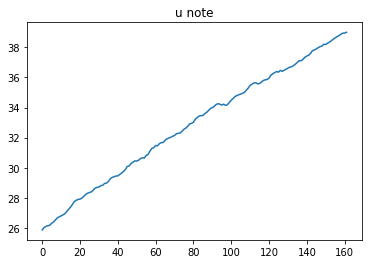

del_note(<= 0.35 ): 0.225910207047459 pass
del_sp(< 1e-06 ): 1.0201446434133266e-13
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
e 分析結果:
最低音限制(< 26 ): 25.861 pass
最高音限制(> 39 ): 39.069 pass


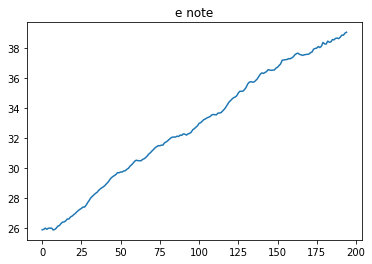

del_note(<= 0.35 ): 0.24435135372207384 pass
del_sp(< 1e-06 ): 4.43025115602247e-10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
o 分析結果:
最低音限制(< 26 ): 25.863 pass
最高音限制(> 39 ): 39.051 pass


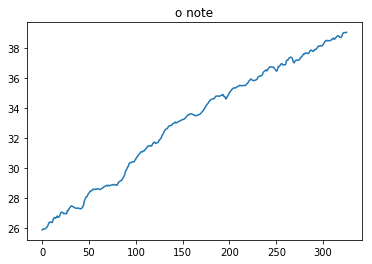

del_note(<= 0.35 ): 0.308710617494242 pass
del_sp(< 1e-06 ): 2.3241624260667293e-11
your pitch range: [26.0, 39.0]
saved pitch range: [26, 39]
==================結果===================
恭喜! 您的音檔可以使用，感謝您的配合!


In [7]:
# pass_list = [0,0,0,0,0]
# clip_lower,clip_upper = 0,100

clip_lower,clip_upper = 26,39
#28 38 9 男
#32 42 9 女

from termcolor import colored
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os.path

import soundfile as sf
# import librosa
import pyworld as pw

subject_note_lower = 0
subject_note_upper = 100

frame_period = 10.0 # millisecond
samples_per_frame = int(np.floor(44100.0 * frame_period/1000.0))

aiueo = ['a','i','u','e','o']

max_del_note = 0.35
del_sp_upper = 0.000001  #1.7
def get_valid_f0_idx(f0,max_note,min_note,tol = 1):
    f0_max = 440*np.power(2,(max_note-49.0)/12.0)
    f0_min = 440*np.power(2,(min_note-49.0)/12.0)
    idx = np.where(np.logical_and(f0>=f0_min-tol, f0<=f0_max+tol))
    return idx

for i in range(len(aiueo)):
    if pass_list[i]:
        print(aiueo[i] , "pass")
        continue
    isPass = True
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    file_cnt = 2
    wavname = 'data/'+aiueo[i]
    if not os.path.isfile(wavname+'.wav'):
        print(colored('錯誤:找不到音檔','red'),wavname+'.wav')
        continue

    x, fs = sf.read(wavname+'.wav')

    if fs != 44100:
        print("錯誤:請使用44100採樣率(sample rate:44100)")
        continue
    try:
        x = (x[:,0] + x[:,1])/2 # stereo to mono
        x = x/max(x)*0.5
    except:
        print("錯誤:請使用雙聲道(stereo 2 channel)錄音")
        continue
    num_of_frames = int(np.floor(len(x)/samples_per_frame))    
    f0, sp, _ = pw.wav2world(x, fs, frame_period =  frame_period)    # use default options

    print(aiueo[i],'分析結果:')   
    

    f0 = f0[1:]    
    sp = sp[1:]

    #criteria 2:minimun delta note (sorted) 
    
    #if there exist 2 file with same vowel, detect its f0 as well
    while os.path.isfile(wavname+str(file_cnt)+'.wav'):
        print('include',str(file_cnt)+'.wav' )
        x2,_ = sf.read(wavname+str(file_cnt)+'.wav')
        x2 = (x2[:,0] + x2[:,1])/2 # stereo to mono
        x2 = x2/max(x2)*0.5
        f02, sp2,_ = pw.wav2world(x2, fs, frame_period =  frame_period)    # use default options
        f02 = f02[1:]
        sp2 = sp2[1:]
        f0 =np.concatenate((f0,f02), axis=0)
        sp =np.concatenate((sp,sp2), axis=0)
        file_cnt += 1

    idx = get_valid_f0_idx(f0,clip_upper,clip_lower)
    f0_note = 12*np.log2(f0[idx]/440)+49
    
    #criteria 1: max pitch ,min pitch
    print("最低音限制(<",clip_lower,"):",round(min(f0_note),3),"pass" if min(f0_note)<clip_lower else "fail")
    print("最高音限制(>",clip_upper,"):",round(max(f0_note),3),"pass" if max(f0_note)>clip_upper else "fail")
    if (not max(f0_note)>clip_upper) or ((not min(f0_note)<clip_lower)):
        isPass = False 
  
    #min_his = min(np.histogram(f0_note, bins=13)[0])
    sp = sp[idx]
    subject_note_lower = max(np.ceil(min(f0_note)),subject_note_lower)
    subject_note_upper = min(np.floor(max(f0_note)),subject_note_upper)
    
    plt.title(aiueo[i]+' note')
    plt.plot(f0_note)
    plt.show()

    sorted_note = np.array(sorted(i for i in f0_note if i < clip_upper+1))
    del_note = abs(sorted_note[1:] - sorted_note[:-1])
    
    if (not max(del_note)<=max_del_note):
        isPass = False
        
        plt.plot(sorted_note)
        plt.title(aiueo[i]+' sorted note')
        plt.show()
        plt.title(aiueo[i]+' del note')
        plt.plot(del_note)
        plt.show()
    print("del_note(<=",max_del_note,"):",max(del_note),"pass" if max_del_note>=max(del_note) else "fail")
    
    #criteria 3:prevent noise 
    del_sp = np.mean(np.power(abs(sp[2:-1,400:]-sp[1:-2,400:]),2),axis= 1)
    max_del_sp = max(del_sp)
    
#     plt.plot(del_sp)
#     plt.show()
    print("del_sp(<",del_sp_upper,"):",max_del_sp)
    if (not max_del_sp<del_sp_upper):
        print("Warning: the audio file might contain noise, please check")
        plt.plot(del_sp)
        plt.show()

    if isPass:
        pass_list[i] = 1
        
pitch_range_file = open(r'./data/pRange.pkl', 'wb')
pickle.dump([clip_lower,clip_upper], pitch_range_file)
pitch_range_file.close()
print("your pitch range:" ,[subject_note_lower,subject_note_upper])

print("saved pitch range:" ,[clip_lower,clip_upper])
print("==================結果===================")
if sum(pass_list) == len(aiueo):
    print("恭喜! 您的音檔可以使用，感謝您的配合!")
else:
    print("您提供的音檔尚有地方須修正，煩請改進fail與錯誤的部分")

### Synthesis test

In [153]:
import os
import soundfile as sf
import pyworld as pw
import matplotlib.pyplot as plt

aiueo = ['a','i','u','e','o']

note_step=0.25
frame_period = 10.0 # millisecond
def get_f0_index_tbl(f0,min_note,max_note,note_step=0.25):
    f0_note = 12*np.log2(f0/440)+49
    out_len = int((max_note-min_note)/note_step+1)
    note_lin =np.linspace(min_note, max_note, num=out_len)
    idx_out = np.zeros(out_len,dtype = int)
    for i in range(out_len):
        idx_out[i] = np.argmin(abs(f0_note-note_lin[i]))
    return idx_out

rangePath = os.path.join('data',"pRange.pkl")
[min_note,max_note] = pickle.load(open(rangePath, "rb"))
print(min_note,max_note)
yy = np.array([0])
for v in aiueo:
    path = os.path.join('data',v)
    print(path)
    x,fs = sf.read(path+'.wav')
    x = (x[:,0] + x[:,1])/2 
    x = x/max(x)*0.5
    f0, sp, ap = pw.wav2world(x, fs, frame_period =  frame_period)
    f0 = f0[1:-1]
    sp = sp[1:-1,:]
    ap = ap[1:-1]
    file_cnt = 2
    while os.path.isfile(path+str(file_cnt)+'.wav'):
        print(path+str(file_cnt)+'.wav')
        x2,_ = sf.read(path+str(file_cnt)+'.wav')
        x2 = (x2[:,0] + x2[:,1])/2 # stereo to mono
        f02, sp2,ap2 = pw.wav2world(x2, fs, frame_period =  frame_period)    # use default options

        f0 =np.concatenate((f0,f02[1:-1]), axis=0)
        sp =np.concatenate((sp,sp2), axis=0)
        ap = np.concatenate((ap,ap2), axis=0)
        file_cnt +=1
#   remove f0 detect fail frame
    valid_idx = np.where(f0!=0)
    f0 =  f0[valid_idx]
    sp =  sp[valid_idx]
    ap =  ap[valid_idx]
    
    
    idx = get_f0_index_tbl(f0,min_note,max_note,note_step)  
    sp =  sp[idx,:]
    ap = ap[idx]
#     plt.plot( f0[idx])
#     plt.show()
    
    lin_f0 = np.linspace(min_note, max_note,num=len(idx))
    f0 = 440*np.power(2,(lin_f0-49.0)/12.0)
    
#     _y = pw.synthesize(f0, sp, ap[:len(idx)], fs, frame_period = 20)
    _y = pw.synthesize(f0, sp, ap, fs, frame_period = 20)
    
    yy = np.concatenate((yy,_y),axis = 0)
sf.write('out.wav', yy, fs)
print('done')

25 36
data\a
data\i
data\u
data\e
data\o
done


[27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75
 30.   30.25 30.5  30.75 31.   31.25 31.5  31.75 32.   32.25 32.5  32.75
 33.   33.25 33.5  33.75 34.   34.25 34.5  34.75 35.   35.25 35.5  35.75
 36.   36.25 36.5  36.75 37.  ]


In [27]:
foo = pickle.load(open("data/pRange.pkl", "rb"))
print(foo)

[26.0, 38.0]


In [41]:
g = np.array([0,1,2,3,4,5,6,7])
b = np.array([0,1,2,3,4,10,7])


print(set(g) & set(b))

{0, 1, 2, 3, 4, 7}
